In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'grid'])
mpl.rcParams["font.size"] = "12"

import torch
import torch.nn.init as init

from modules.utils import FeedForwardNetwork, plot_ode, plot_losses, rmse
from modules.problems import LotkaVolterra

In [3]:
def train(
    problem,
    model,
    w1, w2, w3, num_iters, N_D, lr,
    collect_every=1000, print_every=1000, save_every=1000
):
    collocation_points = torch.linspace(0, problem.T, N_D, requires_grad=True).reshape(-1, 1)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses, errors = [], []

    for i in range(num_iters + 1):

        optimizer.zero_grad()

        L_I = problem.loss_initial(model)
        L_X, L_Y = problem.loss_physical(model, collocation_points)

        L = w1 * L_I + w2 * L_X + w3 * L_Y

        L.backward()
        optimizer.step()
        
        if i % collect_every == 0:
            preds = model(problem.t.reshape(-1, 1)).detach().numpy()
            x = preds[:,0].flatten()
            y = preds[:,1].flatten()

            error_x = rmse(x, problem.solution[0])
            error_y = rmse(y, problem.solution[1])

            losses.append(np.array([L_I.item(), L_X.item(), L_Y.item(), L.item()]))
            errors.append(np.array([error_x, error_y]))
        
        if i % print_every == 0:
            print(f'Iteration {i} --- {error_x}, {error_y}')
    
    return np.array(losses), np.array(errors)

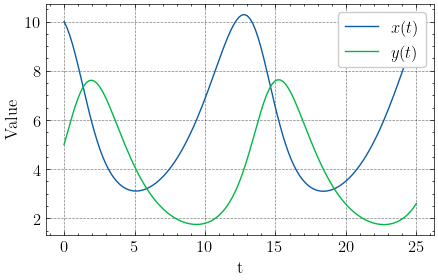

In [3]:
T = 25
alpha, beta, delta, gamma = 0.4, 0.1, 0.1, 0.6
x_0, y_0 = 10, 5
problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])

plot_ode(problem.t.numpy(), [(problem.solution[0], r'$x(t)$', None), ((problem.solution[1], r'$y(t)$', None))], size=(5, 3))

In [ ]:
L, W = 2, 32
model = FeedForwardNetwork(L, W, input_dim=1, output_dim=2)
model.init_weights(init.zeros_)

w1, w2, w3 = 1, 2, 2
num_iters = 10000
N_D = 1024
lr = 1e-2
collect_every = 500

losses, errors = train(
    problem,
    model,
    w1, w2, w3, num_iters, N_D, lr,
    collect_every=collect_every, print_every=2500
)

In [ ]:
preds = model(problem.t.reshape(-1, 1)).detach().numpy()
x = preds[:,0].flatten()
y = preds[:,1].flatten()

plot_ode(
    problem.t.numpy(), 
    solutions=[(problem.solution[0], r'$x(t)$'), (problem.solution[1], r'$y(t)$')],
    predicted=[(x, r'$\mathcal{X}(t)$'), (y, r'$\mathcal{Y}(t)$')],
    title='Lotka-Volterra System', size=(5, 3)
)

In [ ]:
plot_losses(
    np.arange(0, num_iters+1, collect_every),
    losses=[
        (losses[:,0], r'$\mathcal{L_I}$'),
        (losses[:,1], r'$\mathcal{L_X}$'),
        (losses[:,2], r'$\mathcal{L_Y}$'),
        (losses[:,3], r'$\mathcal{L_T}$')
    ],
    errors=[
        (errors[:,0], r'$\mathcal{X}(t)$'),
        (errors[:,1], r'$\mathcal{Y}(t)$')
    ]
)

## Interesting problem statements
---

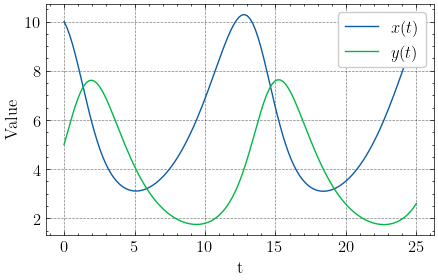

In [5]:
# Default
T = 25
alpha, beta, delta, gamma = 0.4, 0.1, 0.1, 0.6
x_0, y_0 = 10, 5
problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])
plot_ode(problem.t.numpy(), [(problem.solution[0], r'$x(t)$', None), ((problem.solution[1], r'$y(t)$', None))], size=(5, 3))

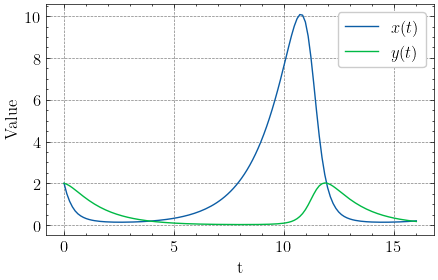

In [101]:
# Pretty sharp solution.
T = 16
alpha, beta, delta, gamma = 0.7, 1.5, 0.3, 0.7
x_0, y_0 = 2, 2
problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])
plot_ode(problem.t.numpy(), [(problem.solution[0], r'$x(t)$', None), ((problem.solution[1], r'$y(t)$', None))], size=(5, 3))

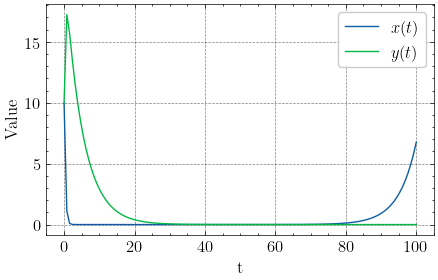

In [90]:
# This solution is exhibit pretty usual behavior for L-V system.
T = 100
alpha, beta, delta, gamma = 0.2, 0.2, 0.2, 0.2
x_0, y_0 = 10, 10
problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])
plot_ode(problem.t.numpy(), [(problem.solution[0], r'$x(t)$', None), ((problem.solution[1], r'$y(t)$', None))], size=(5, 3))

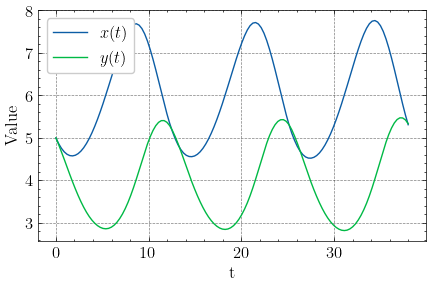

In [62]:
# Default parameters with different initialization and larger time T.
T = 38
alpha, beta, delta, gamma = 0.4, 0.1, 0.1, 0.6
x_0, y_0 = 5, 5
problem = LotkaVolterra(T, (alpha, beta, delta, gamma), [x_0, y_0])
plot_ode(problem.t.numpy(), [(problem.solution[0], r'$x(t)$', None), ((problem.solution[1], r'$y(t)$', None))], size=(5, 3))